# Classificação de CHURN de uma companhia de **Telecomunicações**

## Apresentação

A partir do conjunto de dados fornecido pelo site ***Maven Analytics*** que diz respeito a uma TELECOM, será feita uma análise exploratória e uma adaptação de modelo de classificação para tentar determinar se um cliente deixará de contratar o serviço fornecido pela empresa, o que é conhecido por CHURN.




## Datasets

Os 3 conjuntos de dados estão disponíveis na pasta do projeto. Eles são 3:

1) Uma tabela com informações detalhadas de clientes que já contrataram algum serviço

2) Uma tabela com a legenda dos nomes das colunas utilizadas na primeira

3) Uma tabela com os zipcodes de residência de cada cliente e sua respectiva população

Inicialmente, vamos carregar os datasets para conhecê-los melhor. O canho aqui descrito possui esse formato pois os arquivos foram carregados no Google Colab

In [1]:
#Importação de bibliotecas básicas necessárias para o desenvolvimento do projeto
import pandas as pd
import numpy as np

dados_clientes = pd.read_csv('telecom_customer_churn.csv')
zipcodes_populacao = pd.read_csv('telecom_zipcode_population.csv')

#O arquivo a seguir não pôde ser decodificado inteiramento em utf-8, é necessário buscar outra decodificação
legendas = pd.read_csv('telecom_data_dictionary.csv',encoding='ISO 8859-1')

In [2]:
#Como o nome das tabelas parece indicar, é possível associar a população de cada zipcode de um cliente a esse próprio cliente. 
#Ainda não é possível descartar que a população da região de um cliente influencia na sua permanência com a empresa ou não, então, 
#vamos unificar essas duas tabelas utilizando o zipcode como chave

print('Colunas dados_clientes', dados_clientes.columns)
print('Colunas zipcodes_populacao',zipcodes_populacao.columns)

Colunas dados_clientes Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')
Colunas zipcodes_populacao Index(['Zip Code', 'Population'], dtype='object')


In [3]:
#Unificando as duas tabelas:

dados_clientes = pd.merge(dados_clientes, zipcodes_populacao, on='Zip Code', how = 'left') 
#O parâmetro left permite não excluir nenhum cliente, ao mesmo tempo que ter um zipcode não associado a um cliente não nos interessa

dados_clientes.head()

Customer ID  Gender  Age Married  Number of Dependents          City  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3  0011-IGKFF    Male   78     Yes                     0      Martinez   
4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   

   Zip Code   Latitude   Longitude  Number of Referrals  ...  Monthly Charge  \
0     93225  34.827662 -118.999073                    2  ...            65.6   
1     91206  34.162515 -118.203869                    0  ...            -4.0   
2     92627  33.645672 -117.922613                    0  ...            73.9   
3     94553  38.014457 -122.115432                    1  ...            98.0   
4     93010  34.227846 -119.079903                    3  ...            83.9   

  Total Charges Total Refunds  Total Extra Data Charges  \
0        593.30          0.00                         0   
1        542.40         38.33                        10   
2        280.85          0.00                         0   
3       1237.85          0.00                         0   
4        267.40          0.00                         0   

  Total Long Distance Charges Total Revenue Customer Status   Churn Category  \
0                      381.51        974.81          Stayed              NaN   
1                       96.21        610.28          Stayed              NaN   
2                      134.60        415.45         Churned       Competitor   
3                      361.66       1599.51         Churned  Dissatisfaction   
4                       22.14        289.54         Churned  Dissatisfaction   

                    Churn Reason Population  
0                            NaN       4498  
1                            NaN      31297  
2  Competitor had better devices      62069  
3        Product dissatisfaction      46677  
4            Network reliability      42853  

[5 rows x 39 columns]

In [4]:
#Agora, vamos eliminar algumas colunas que claramente não influenciam na decisão de um cliente permanecer ou não com a empresa
dados_clientes.drop(columns = ['Customer ID', #A identificação atribuída a um cliente é provavelmente desconhecida pelo próprio
                               'Zip Code', #Já temos a cidade onde o cliente reside, o que é equivalente
                               'Latitude', #Já temos a cidade onde o cliente reside, o que é equivalente (vamos desconsiderar problemas estritamente locais)
                               'Longitude', #Já temos a cidade onde o cliente reside, o que é equivalente (vamos desconsiderar problemas estritamente locais)
                               'Churn Category', #Pode enviesar os resultados sabermos de antemão a categoria na qual o cliente se encaixa
                               'Churn Reason', #Pode enviesar os resultados sabermos de antemão porque um cliente deixou de contratar os serviços
                               ], inplace = True)

In [5]:
#Agora, com relação às nossas labels, elas serão identificadas pela coluna 'Customer Status'. Porém há 3 categorias diferentes:
dados_clientes['Customer Status'].unique()

array(['Stayed', 'Churned', 'Joined'], dtype=object)

In [6]:
#Não estamos interessados em analisar clientes que acabaram de contratar um serviço, já que sequer tiveram tempo para poder deixar a empresa.
dados_clientes = dados_clientes[dados_clientes['Customer Status'] != 'Joined']
dados_clientes.reset_index(inplace = True,drop = True) #Reseta o index do dataframe, para evitar possíveis erros mais pra frente

#Além das colunas já eliminadas, temos a coluna que representará nossas labels para o modelo de classificação
y = dados_clientes['Customer Status']

#Agora podemos definir nossas features
x = dados_clientes.drop(columns = 'Customer Status')

## Limpeza de dados

### Dados nulos

In [7]:
#Primeiramente, vamos identificar se há alguma coluna com excesso de dados nulos
x.isnull().sum()

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     644
Multiple Lines                        644
Internet Service                        0
Internet Type                        1344
Avg Monthly GB Download              1344
Online Security                      1344
Online Backup                        1344
Device Protection Plan               1344
Premium Tech Support                 1344
Streaming TV                         1344
Streaming Movies                     1344
Streaming Music                      1344
Unlimited Data                       1344
Contract                                0
Paperless Billing                 

In [8]:
#Consultando a tabela de legendas, é possível concluir que as colunas que possuem dados nulos são vinculadas à contratação de um serviço em específico,
#sendo ele telefone ou internet. Assim, vamos substituir os dados nulos por 'Não contratado' quando o tipo da coluna for string, e por 0 quando o tipo
#for numérico. Há apenas duas dessas colunas que são númericas. Vamos primeiro ajustar essas e depois ajustar o restante do dataframe como um todo
x.isnull().sum()[x.isnull().sum()>0].keys()

Index(['Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data'],
      dtype='object')

In [9]:
x['Avg Monthly Long Distance Charges'] = x['Avg Monthly Long Distance Charges'].fillna(0)
x['Avg Monthly GB Download'] = x['Avg Monthly GB Download'].fillna(0)
x = x.fillna('Não contratado')

#Uma alternativa seria eliminar essas colunas que dependem de outras para possui dados válidos. Porém, é possível que os clientes deixem a empresa justamente
#por causa de um desses serviços dependentes. Aqui optamos por manter essas colunas

### Dados com baixa variância

In [10]:
#Vamos separar as colunas em dois tipos: numéricas e categóricas nominais. 
#Para as primeiras, identificaremos as variâncias graficamente e eliminaremos os violinos simétricos

matriz_correlacao = x.corr()
colunas_numericas = list(matriz_correlacao.columns)
colunas_numericas_plot = colunas_numericas + ['Customer Status']

# Importa as bibliotecas necessárias para plotar um gráfico do tipo violinplot.
import seaborn as sns
import matplotlib.pyplot as plt

#Vamos transformar o dataframe 'dados_clientes' para que possamos plotar todas as variáveis simultaneamente
dados_plot = pd.melt(dados_clientes[colunas_numericas_plot], id_vars='Customer Status', 
                     value_vars=None, var_name='Variável', value_name='Valores', 
                     col_level=None, ignore_index=True)
dados_plot

Customer Status    Variável  Valores
0              Stayed         Age     37.0
1              Stayed         Age     46.0
2             Churned         Age     50.0
3             Churned         Age     78.0
4             Churned         Age     75.0
...               ...         ...      ...
85652         Churned  Population  42239.0
85653          Stayed  Population  44652.0
85654         Churned  Population  16525.0
85655          Stayed  Population  12173.0
85656          Stayed  Population    348.0

[85657 rows x 3 columns]

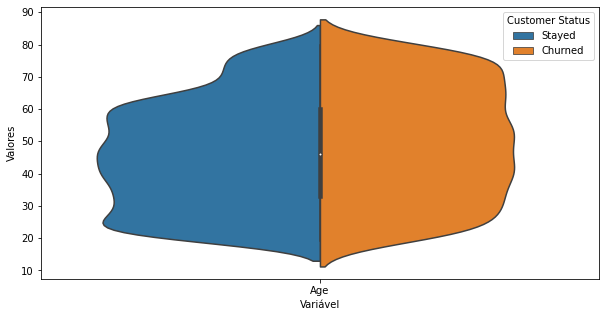

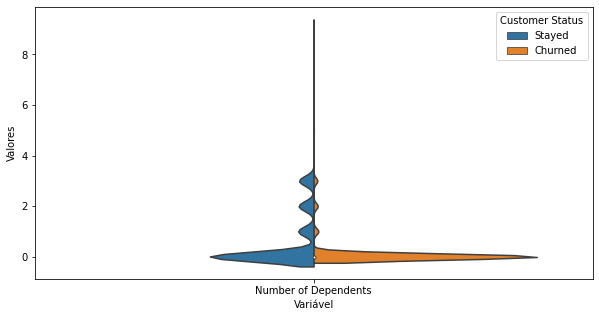

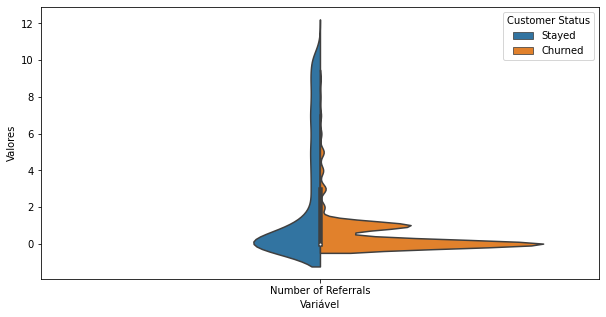

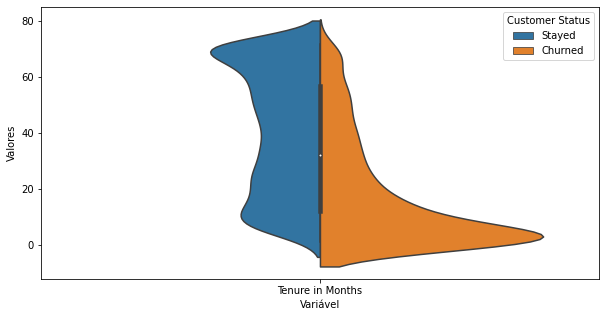

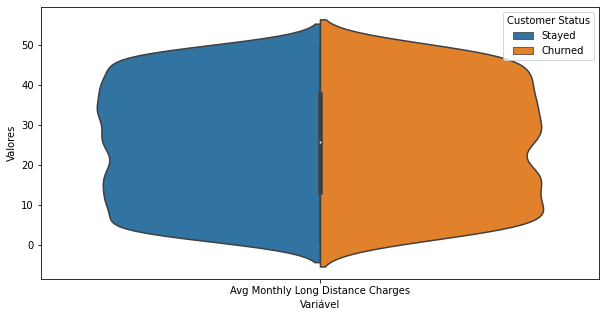

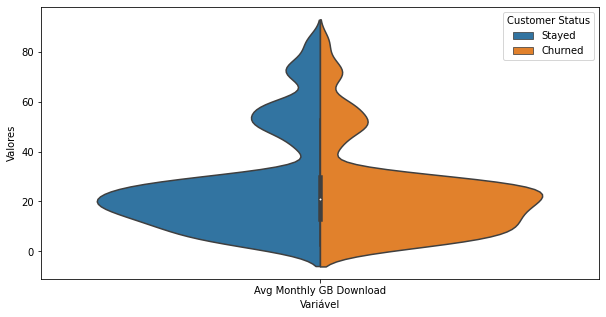

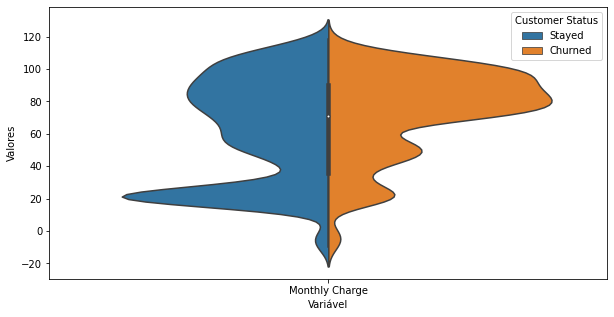

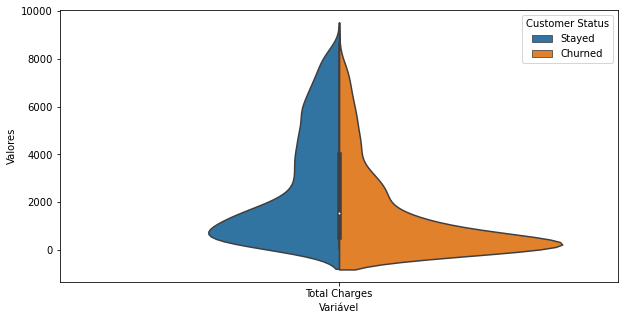

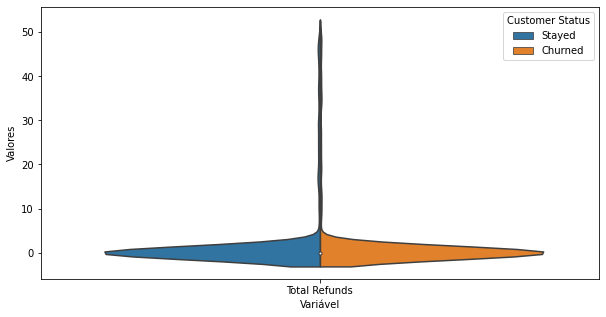

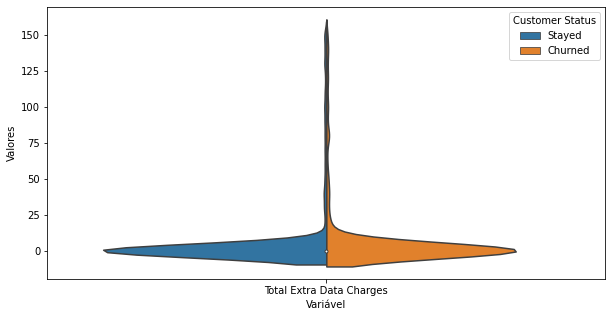

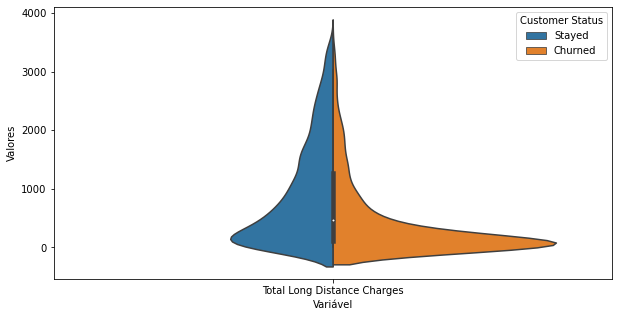

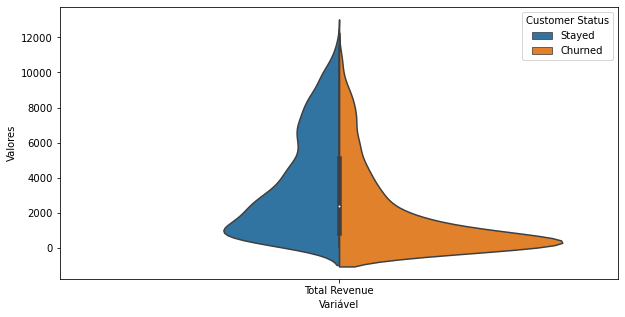

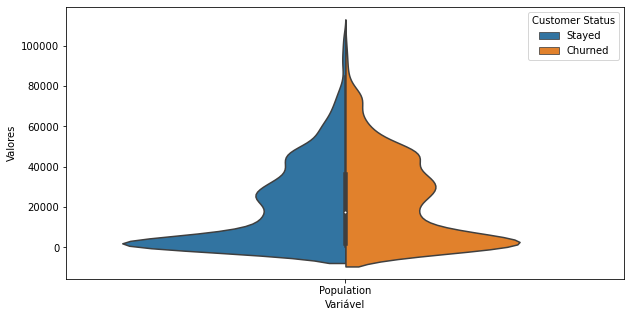

In [11]:
#Para não poluirmos as informações em apenas um gráfico, criaremos uma função para visualizar uma variável por vez (temos 13 colunas numéricas no total)

def plota_violino(variavel):

  plt.figure(figsize=(10, 5)) #Estabelece o tamanho do gráfico
  sns.violinplot(x = "Variável", y = "Valores", hue = "Customer Status",
                data = dados_plot[dados_plot['Variável'] == variavel], split = True,) #O parâmero split unifica as duas categorias em apenas um violino

for variavel in colunas_numericas:
  plota_violino(variavel)

In [12]:
#Podemos tirar algumas conclusões interessantes a respeito desses gráficos

#Age: até cerca de 60 anos aparenta uma simetria, depois disso há clara distinção para o CHURN. Talvez seja possível tornar essa variável binária
#Number of dependents: ligeiramente assimétrico
#Number of Referrals: assimétrico
#Tenure in Months: assimétrico
#Avg Monthly Long Distance Charges: simetria forte aparente
#Avg Monthly GB Download: simetria forte aparente
#Monthly Charge: assimétrico
#Total Charges: ligeiramente simétrico
#Total Refunds: semelhante à coluna 'Age', talvez possamos dividir os dados entre abaixo de 5 e acima ou igual a 5
#Total Extra Data Charges: simetria forte aparente
#Total Long Distance Charges: ligeiramente assimétrico
#Total Revenue: assimétrico
#Population: simetria forte aparente

#Uma alternativa talvez seja analisar matematicamente, para termos certeza de eliminar as colunas corretas:
dados_clientes[colunas_numericas_plot].groupby('Customer Status').var().transpose()

Customer Status                         Churned        Stayed
Age                                3.099322e+02  2.683865e+02
Number of Dependents               3.023918e-01  1.118988e+00
Number of Referrals                1.198295e+00  1.104848e+01
Tenure in Months                   3.814648e+02  5.001339e+02
Avg Monthly Long Distance Charges  2.021107e+02  2.014365e+02
Avg Monthly GB Download            3.231080e+02  4.077617e+02
Monthly Charge                     6.955754e+02  1.036760e+03
Total Charges                      3.575212e+06  5.301938e+06
Total Refunds                      4.958458e+01  7.236041e+01
Total Extra Data Charges           6.178875e+02  6.849115e+02
Total Long Distance Charges        4.229659e+05  7.768613e+05
Total Revenue                      5.945998e+06  8.139259e+06
Population                         4.575529e+08  4.455139e+08

In [13]:
#Vamos então realizar as devidas modificações nas variáveis numéricas

#A coluna age será agora binária. 60 anos ou mais será representado por 1, e abaixo disso será representado por 0.
x['Age'] = x['Age'].apply(lambda x: 1 if x >= 60 else 0)

#A coluna Total Refunds será agora binária. 5 ou mais será representado por 1, e abaixo disso será representado por 0.
x['Total Refunds'] = x['Total Refunds'].apply(lambda x: 1 if x >= 5 else 0)

#As colunas 'Avg Monthly Long Distance Charges', 'Total Extra Data Charges' e 'Population' não e representam diferenças significativas entre os grupos. Logo, podemos retirá-las
x.drop(columns = ['Avg Monthly Long Distance Charges', 'Total Extra Data Charges', 'Population'], inplace = True)

In [14]:
#Agora, vamos avaliar as variáveis categóricas
colunas_categoricas = list(x.columns[x.columns.isin(colunas_numericas) == False])

x[colunas_categoricas].describe()

Gender Married       City Offer Phone Service Multiple Lines  \
count    6589    6589       6589  6589          6589           6589   
unique      2       2       1106     6             2              3   
top      Male     Yes  San Diego  None           Yes             No   
freq     3312    3318        278  3598          5945           3019   

       Internet Service Internet Type Online Security Online Backup  \
count              6589          6589            6589          6589   
unique                2             4               3             3   
top                 Yes   Fiber Optic              No            No   
freq               5245          2934            3272          2870   

       Device Protection Plan Premium Tech Support Streaming TV  \
count                    6589                 6589         6589   
unique                      3                    3            3   
top                        No                   No          Yes   
freq                     2855                 3248         2658   

       Streaming Movies Streaming Music Unlimited Data        Contract  \
count              6589            6589           6589            6589   
unique                3               3              3               3   
top                 Yes              No            Yes  Month-to-Month   
freq               2683            2809           4521            3202   

       Paperless Billing   Payment Method  
count               6589             6589  
unique                 2                3  
top                  Yes  Bank Withdrawal  
freq                3974             3728

In [15]:
#Precisamos identificar quais os valores únicos para cada coluna, para talvez transformá-las em binárias
for coluna in colunas_categoricas:
  print(coluna, x[coluna].unique())

Gender ['Female' 'Male']
Married ['Yes' 'No']
City ['Frazier Park' 'Glendale' 'Costa Mesa' ... 'Kirkwood' 'Carpinteria'
 'Meadow Valley']
Offer ['None' 'Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']
Phone Service ['Yes' 'No']
Multiple Lines ['No' 'Yes' 'Não contratado']
Internet Service ['Yes' 'No']
Internet Type ['Cable' 'Fiber Optic' 'DSL' 'Não contratado']
Online Security ['No' 'Yes' 'Não contratado']
Online Backup ['Yes' 'No' 'Não contratado']
Device Protection Plan ['No' 'Yes' 'Não contratado']
Premium Tech Support ['Yes' 'No' 'Não contratado']
Streaming TV ['Yes' 'No' 'Não contratado']
Streaming Movies ['No' 'Yes' 'Não contratado']
Streaming Music ['No' 'Yes' 'Não contratado']
Unlimited Data ['Yes' 'No' 'Não contratado']
Contract ['One Year' 'Month-to-Month' 'Two Year']
Paperless Billing ['Yes' 'No']
Payment Method ['Credit Card' 'Bank Withdrawal' 'Mailed Check']


In [16]:
#Bom, a princípio, a coluna 'City' também pode ser eliminada, já que possui um alto número de cidades distintas para proporcionalmente baixa quantidade total de dados (média de 6 clientes por cidade).
#Logo, a maior parte das cidades trará informações estatisticamente irrelevantes
x.drop(columns = 'City', inplace = True)

In [17]:
#As colunas 'Offer', 'Internet Type', 'Contract' e 'Payment Method' precisam ser analisadas mais a fundo. Se encontrarmos uma uniformidade nos dados, podemos descartá-las.
df_analise_categ = pd.concat([x[['Offer', 'Internet Type', 'Contract', 'Payment Method']],dados_clientes['Customer Status']],axis = 1)

#Podemos converter o dataframe em variáveis binárias e depois agruparmos 
df_analise_categ_dummy = pd.get_dummies(df_analise_categ)

df_analise_categ_dummy.head()

Offer_None  Offer_Offer A  Offer_Offer B  Offer_Offer C  Offer_Offer D  \
0           1              0              0              0              0   
1           1              0              0              0              0   
2           0              0              0              0              0   
3           0              0              0              0              1   
4           1              0              0              0              0   

   Offer_Offer E  Internet Type_Cable  Internet Type_DSL  \
0              0                    1                  0   
1              0                    1                  0   
2              1                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   Internet Type_Fiber Optic  Internet Type_Não contratado  \
0                          0                             0   
1                          0                             0   
2                          1                             0   
3                          1                             0   
4                          1                             0   

   Contract_Month-to-Month  Contract_One Year  Contract_Two Year  \
0                        0                  1                  0   
1                        1                  0                  0   
2                        1                  0                  0   
3                        1                  0                  0   
4                        1                  0                  0   

   Payment Method_Bank Withdrawal  Payment Method_Credit Card  \
0                               0                           1   
1                               0                           1   
2                               1                           0   
3                               1                           0   
4                               0                           1   

   Payment Method_Mailed Check  Customer Status_Churned  \
0                            0                        0   
1                            0                        0   
2                            0                        1   
3                            0                        1   
4                            0                        1   

   Customer Status_Stayed  
0                       1  
1                       1  
2                       0  
3                       0  
4                       0

In [18]:
#Podemos analisar a porcentagem de CHURN em cada nova coluna. Se as porcentagens forem semelhantes, eliminamos toda a cetegoria de uma vez
df_analise_churn = df_analise_categ_dummy.sum().to_frame()
df_analise_churn.columns = ['Total']

df_analise_churn_b = df_analise_categ_dummy[df_analise_categ_dummy['Customer Status_Churned'] == 1].sum().to_frame()
df_analise_churn_b.columns = ['CHURN']

df_analise_churn = pd.concat([df_analise_churn,df_analise_churn_b],axis = 1)
df_analise_churn['% CHURN'] = df_analise_churn['CHURN']/df_analise_churn['Total']
df_analise_churn

Total  CHURN   % CHURN
Offer_None                       3598   1051  0.292107
Offer_Offer A                     520     35  0.067308
Offer_Offer B                     824    101  0.122573
Offer_Offer C                     415     95  0.228916
Offer_Offer D                     602    161  0.267442
Offer_Offer E                     630    426  0.676190
Internet Type_Cable               774    213  0.275194
Internet Type_DSL                1537    307  0.199740
Internet Type_Fiber Optic        2934   1236  0.421268
Internet Type_Não contratado     1344    113  0.084077
Contract_Month-to-Month          3202   1655  0.516864
Contract_One Year                1526    166  0.108781
Contract_Two Year                1861     48  0.025793
Payment Method_Bank Withdrawal   3728   1329  0.356491
Payment Method_Credit Card       2518    398  0.158062
Payment Method_Mailed Check       343    142  0.413994
Customer Status_Churned          1869   1869  1.000000
Customer Status_Stayed           4720      0  0.000000

In [19]:
#Os tipos de ofertas, de conexão de internet, de contrato e de método de pagamento variam bastante com relação ao percentual de CHURN. Logo, não é interessante eliminar essas variáveis.
#Unificando os dataframes resultantes:
colunas_categoricas.remove('City')
x = pd.concat([x.drop(columns = colunas_categoricas),df_analise_categ_dummy.iloc[:,:-2]], axis = 1)

## Avaliando a correlação

In [20]:
#O objetivo aqui é eliminar variáveis fortemente correlacionadas, já que para um modelo de classificação elas seriam apenas repetições de informação
matriz_correlacao = x.corr()
matriz_correlacao_v1 = matriz_correlacao[matriz_correlacao>0.9] #Aplica uma lógica bolleana sobre a matriz de correlação
matriz_correlacao_v2 = matriz_correlacao_v1.sum() #Evidencia as variáveis correlacionadas fortemente (terão a soma maior do que 1)
variaveis_correlacionadas = matriz_correlacao_v2[matriz_correlacao_v2>1]
colunas_eliminadas = variaveis_correlacionadas.keys() #Evidencia as variáveis correlacionadas
colunas_eliminadas

Index(['Total Charges', 'Total Revenue'], dtype='object')

In [21]:
#Vamos eliminar a coluna 'Total Charges' (escolha arbitrária)
x.drop(columns = 'Total Charges',inplace = True)

In [22]:
#Antes de iniciar o modelo em si, falta apenas converter nossas labels em 0 e 1
y = y.apply(lambda x: 1 if x == 'Churned' else 0)

## Redução de dimensionalidade

In [23]:
#Ainda estamos com muitas features diferentes para avaliar (28 colunas). Vamos primeiramente treinar um modelo utilizando todas as colunas.
#Depois tentaremos selecionar as mais relevantes
#Aqui utilizaremos o algoritmo DecisionTreeClassifier para nosso modelo. Acredito que seja o mais adequado já que temos variáveis numéricas e categóricas em conjunto.
#Assim não há necessidade de convertermos as variáveis categóricas, já que esse algoritmo pode trabalhar muito bem com tal tipo de variável

#Antes, precisamos separar os dados de treino e teste

from sklearn.model_selection import train_test_split

SEED = 1505
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, 
                                                        random_state = SEED, 
                                                        test_size = 0.25,
                                                        stratify = y) #Utilizaremos 25% dos dados para testarmos o modelo, e essa separação seguirá a mesma proporção da distribuição de clientes
                                                                      #cujo CHURN é positivo


from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth=3, random_state = SEED) #max_depth é o número de subdivisões que o classificador fará para tomar uma decisão
modelo.fit(treino_x, treino_y) #Ajusta o modelo aos dados de treino
print('A acurácia do modelo é %.2f%%' % (modelo.score(teste_x,teste_y)*100)) #Calcula a acurácia. Ou seja, a % de previsões corretas do modelo

A acurácia do modelo é 82.16%


In [24]:
#É interessante comparar esse resultado com um modelo mais simples, para verificar se todo o esforço valeu a pena. Vamos utilizar o DummyClassifier
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy= "most_frequent") # Classifica todas as entradas como sendo iguais a mais frequente dentre as labels
dummy_classifier.fit(treino_x, treino_y)
acuracia_dummy = dummy_classifier.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia_dummy)

A acurácia do dummy stratified foi 71.66%


[Text(0.5, 38.5, 'Predição'), Text(56.5, 0.5, 'Real')]

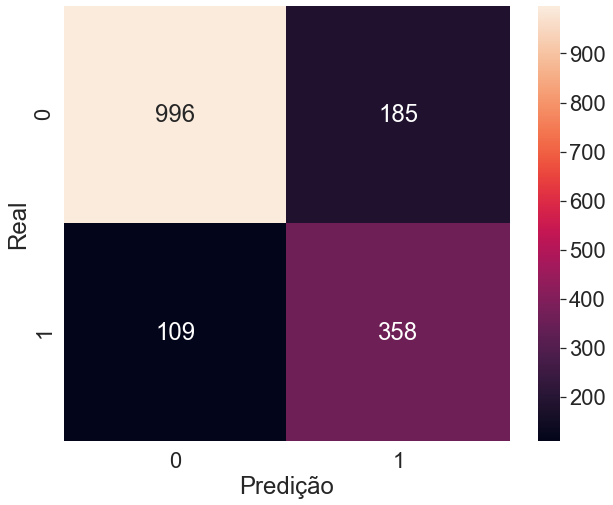

In [25]:
#É interessante também avaliar o desempenho do modelo com base na matriz de confusão

from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(teste_y,modelo.predict(teste_x))

#Plota um esboço de uma matriz de confusão do modelo criado
plt.figure(figsize = (10, 8))
sns.set(font_scale= 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")

[Text(0.5, 38.5, 'Predição'), Text(56.5, 0.5, 'Real')]

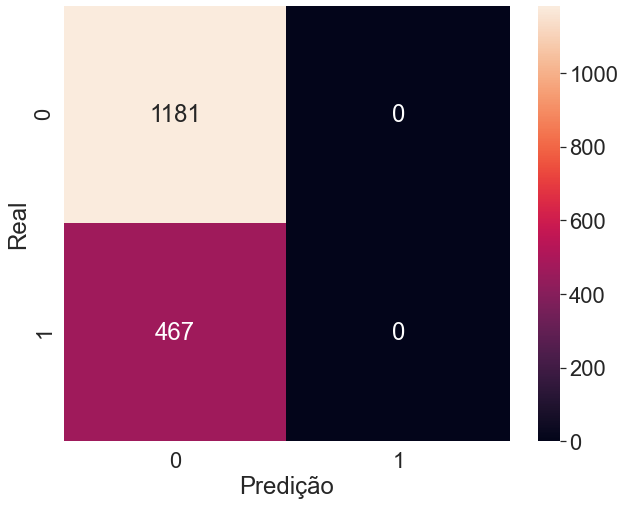

In [26]:
matriz_confusao_dummy = confusion_matrix(teste_y,dummy_classifier.predict(teste_x))

#Plota um esboço de uma matriz de confusão do DummyClassifier
plt.figure(figsize = (10, 8))
sns.set(font_scale= 2)
sns.heatmap(matriz_confusao_dummy, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")

In [26]:
#Com a matriz de confusão, temos duas métricas que podem ser úteis, a precisão e o recall. 
#Vamos primeiro analisar a precisão (porcentagem de acertos dentre todas as previsões dadas como CHURN)

from sklearn.metrics import precision_score #precision

print('A precisão do modelo é %.2f%%' % (precision_score(teste_y, modelo.predict(teste_x))*100))
print('A precisão do DummyClassifier é %.2f%%' % (precision_score(teste_y, dummy_classifier.predict(teste_x))*100))

A precisão do modelo é 65.93%
A precisão do DummyClassifier é 0.00%


C:\Users\m_hen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#Agora vamos fazer o mesmo para o recall

from sklearn.metrics import recall_score #recall

print('O recall do modelo é %.2f%%' % (recall_score(teste_y, modelo.predict(teste_x))*100))
print('O recall do DummyClassifier é %.2f%%' % (recall_score(teste_y, dummy_classifier.predict(teste_x))*100))

O recall do modelo é 76.66%
O recall do DummyClassifier é 0.00%


In [35]:
#Visualizando a árvore criada, é possível avaliar as decisões tomadas pelo modelo

from sklearn.tree import DecisionTreeClassifier

# Para visualizar a árvore resultante:
!pip install graphviz
!apt-get install graphviz

from sklearn.tree import export_graphviz
import graphviz

features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,                          
                           class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [31]:
#A princípio, nosso modelo está levando em consideração apenas 4 dentre todas as as features disponíveis para chegar a esses resultados
#Nosso objetivo é prever com a melhor precisão possível nosso CHURN, já que essa métrica tende a determinar o pior cenário possível para a empresa.
#Assim é possível realizar uma projeção de faturamento e também elaborar políticas para retenção.
#Justamente pensando nessas políticas de retenção, vamos tentar encontrar as melhores features para um novo modelo, tentando ao mesmo tempo simplificá-lo

from sklearn.feature_selection import RFECV

selecionador_rfecv = RFECV(estimator = modelo, cv = 10, step = 2, scoring="accuracy") #Define accuracy como critério de escolha
selecionador_rfecv.fit(treino_x, treino_y)
treino_rfecv = selecionador_rfecv.transform(treino_x)
teste_rfecv = selecionador_rfecv.transform(teste_x)

treino_x.columns[selecionador_rfecv.support_] #Exibe as colunas escolhidas para o modelo

Index(['Tenure in Months', 'Monthly Charge', 'Contract_Month-to-Month'], dtype='object')

In [32]:
#Podemos ajustar um novo modelo com apenas essas features e verificar se temos uma perda considerável de acurácia e precisão

colunas_essenciais = treino_x.columns[selecionador_rfecv.support_]
treino_x_simplificado = treino_x[colunas_essenciais]
teste_x_simplificado = teste_x[colunas_essenciais]

modelo_simplificado = DecisionTreeClassifier(max_depth=3, random_state = SEED) #max_depth é o número de subdivisões que o classificador fará para tomar uma decisão
modelo_simplificado.fit(treino_x_simplificado, treino_y) #Ajusta o modelo aos dados de treino

print('A acurácia do modelo simplificado é %.2f%%' % (modelo_simplificado.score(teste_x_simplificado,teste_y)*100)) #Calcula a acurácia. Ou seja, a % de previsões corretas do modelo
print('A precisão do modelo simplificado é %.2f%%' % (precision_score(teste_y, modelo_simplificado.predict(teste_x_simplificado))*100))

A acurácia do modelo simplificado é 82.16%
A precisão do modelo simplificado é 65.93%


In [33]:
#Em termos de resultados, obtivemos exatamento os mesmo do que quando levaos em consideração todas as mais de 25 features. A árvore de decisão desse novo modelo é:

features = treino_x_simplificado.columns
dot_data = export_graphviz(modelo_simplificado, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,                          
                           class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Validação do modelo

In [34]:
#Apenas para validação desse modelo, vamos utilizar o cross_validate para verificarmos os resultados com diferentes dados de teste

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = True) #KFold quebra os dados em n_splits pedaços, podendo ou não embaralhá-los antes (shuffle).
results = cross_validate(modelo_simplificado, x[colunas_essenciais], y, cv = 10, return_train_score=False) #Roda o modelo 10 vezes, trazendo resultados de cada teste
media = results['test_score'].mean() #Calcula a média de acurácia dentre todos os resultados
desvio_padrao = results['test_score'].std() #Calcula o desvio padrão de acurácia dentre todos os resultados

print('Média da acurácia: %.2f%%' % (media*100))
print('Desvio padrão da acurácia: %.2f%%' % (desvio_padrao*100))
print("Intervalo de confiança da acurácia: [%.2f%%, %.2f%%]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Média da acurácia: 82.26%
Desvio padrão da acurácia: 2.07%
Intervalo de confiança da acurácia: [78.12%, 86.39%]


In [35]:
#Temos que tentar reduzir esse intervalo de confiança. Vamos varrer outros parâmetros do nosso modelo com o GridSearchCV

from sklearn.model_selection import GridSearchCV

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5], #Número máximo de nós
    "min_samples_split" : [32, 64, 128], #Número mínimo de amostras em cada nó
    "min_samples_leaf" : [32, 64, 128], #Número mínimo de amostras em cada folha
    "criterion" : ["gini", "entropy"] #Critério utilizado para tomar a melhor decisão a cada nó
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 10, shuffle = True))
busca.fit(x[colunas_essenciais], y)

melhor = busca.best_estimator_

In [36]:
#Vamos visualizar os melhores parâmetros dentre os indicados no espaco fornecido ao GridSearchCV
print(melhor)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=32, min_samples_split=32)


In [37]:
#Por fim, vamos realizar o cross_validate para nosso modelo final, e verificar seu intervalo de confiança, bem como sua precisão

cv = KFold(n_splits = 10, shuffle = True) #KFold quebra os dados em n_splits pedaços, podendo ou não embaralhá-los antes (shuffle).
results = cross_validate(melhor, x[colunas_essenciais], y, cv = 10, return_train_score=False) #Roda o modelo 10 vezes, trazendo resultados de cada teste
media = results['test_score'].mean() #Calcula a média de acurácia dentre todos os resultados
desvio_padrao = results['test_score'].std() #Calcula o desvio padrão de acurácia dentre todos os resultados

print('Média da acurácia: %.2f%%' % (media*100))
print('Desvio padrão da acurácia: %.2f%%' % (desvio_padrao*100))
print("Intervalo de confiança da acurácia: [%.2f%%, %.2f%%]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))
print('A precisão do modelo é: %.2f%%' % (precision_score(teste_y, melhor.predict(teste_x_simplificado))*100))
print('O recall do modelo é: %.2f%%' % (recall_score(teste_y, melhor.predict(teste_x_simplificado))*100))

Média da acurácia: 83.03%
Desvio padrão da acurácia: 1.70%
Intervalo de confiança da acurácia: [79.64%, 86.43%]
A precisão do modelo é: 84.01%
O recall do modelo é: 52.89%


[Text(0.5, 38.5, 'Predição'), Text(56.5, 0.5, 'Real')]

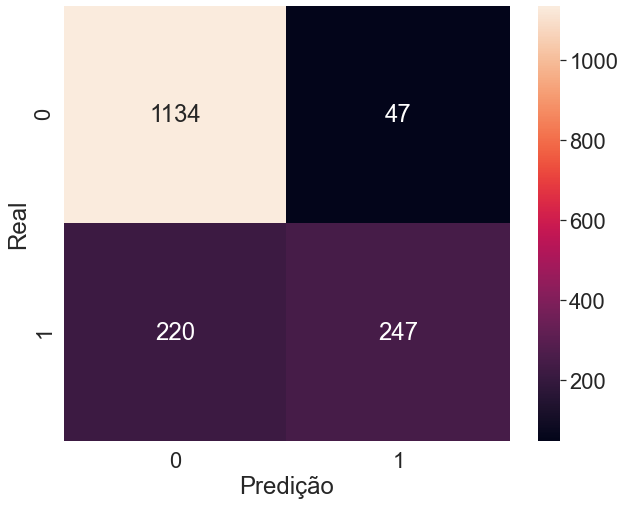

In [38]:
#Como podemos perceber, conseguimos aumentar ligeiramente a média de nossa acurácia, bem como reduzir o desvio padrão
#O que mais chama a atenção, entretanto, é a precisão desse 'melhor modelo', que está bem acima da do primeiro modelo ajustado
#Por outro lado, o seu recall é consideravelmente menor do que do primeiro modelo ajustado. Isso significa que o novo modelo é muito mais conservador ao avaliar um possível CHURN.
#Ou seja, ele praticamente não comete falsos positivos, já que classifica grande parte dos clientes como se fossem permanecer com os serviços da empresa.
#Porém deixa vários clientes que de fato abandonariam a empresa de fora, o que causaria um prejuízo considerável se ele fosse utilizado em projeções
#Vamos olhar em detalhes a matriz de confusão desse 'melhor modelo':

matriz_confusao = confusion_matrix(teste_y,melhor.predict(teste_x_simplificado))

#Plota um esboço de uma matriz de confusão do modelo criado
plt.figure(figsize = (10, 8))
sns.set(font_scale= 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")

In [ ]:
#Entretanto, pensando em políticas de retenção de clientes, esse 'melhor modelo' é muito interessante. 
#Pois permite identificar com boa exatidão o perfil de clientes que deixariam
#a empresa (falsos positivos e verdadeiros positivos). Atuando apenas em cima desse grupo, 
#já seria possível reduzir consideravelmente o seu número.